In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Load dataset

In [3]:
data_path = "mfd/other_mf_corpora/twitter_stance_semeval2016/data/twitter_semeval2016_task6_scored.csv"
stance = pd.read_csv(data_path, index_col=0)
stance.head()

,tweet,target,stance,opinion towards,sentiment,authority_score,care_score,fairness_score,loyalty_score,sanctity_score
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0.957910,0.046491,0.937099,0.565731,0.124335
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,0.711373,0.061669,0.303132,0.565248,0.042299
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0.778991,0.021777,0.310809,0.182060,0.033753
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0.873762,0.178802,0.961251,0.791347,0.113452
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,0.102051,0.022211,0.011203,0.022128,0.038907


In [4]:
# Some stats
print("Total number of tweets:", stance.shape[0])

Total number of tweets: 4870


In [5]:
topics = sorted(stance.target.unique())
stances = sorted(stance.stance.unique())

# Count the number of tweets for each topic and each stance
tweet_count_by_topic = pd.DataFrame(0, index=topics, columns=stances)
for topic in topics:
    for s in stances:
        n = stance[(stance.target == topic) & (stance.stance == s)].shape[0]
        tweet_count_by_topic.loc[topic, s] = n

# Then get total
tweet_count_by_topic["Total"] = tweet_count_by_topic.sum(axis=1)
tweet_count_by_topic.loc["Total"] = tweet_count_by_topic.sum(axis=0)

print("Number of tweets per topic:")
tweet_count_by_topic

Number of tweets per topic:


,AGAINST,FAVOR,NONE,Total
Atheism,464,124,145,733
Climate Change is a Real Concern,26,335,203,564
Donald Trump,299,148,260,707
Feminist Movement,511,268,170,949
Hillary Clinton,565,163,256,984
Legalization of Abortion,544,167,222,933
Total,2409,1205,1256,4870


## Processing

### Remove all tweets with no clear stance

In [6]:
stance = stance[stance.stance != "NONE"]
print("Number of tweets left:", stance.shape[0])

topics = sorted(stance.target.unique())
stances = sorted(stance.stance.unique())

# Count the number of tweets for each topic and each stance
tweet_count_by_topic = pd.DataFrame(0, index=topics, columns=stances)
for topic in topics:
    for s in stances:
        n = stance[(stance.target == topic) & (stance.stance == s)].shape[0]
        tweet_count_by_topic.loc[topic, s] = n

# Then get total
tweet_count_by_topic["Total"] = tweet_count_by_topic.sum(axis=1)
tweet_count_by_topic.loc["Total"] = tweet_count_by_topic.sum(axis=0)
tweet_count_by_topic

Number of tweets left: 3614


,AGAINST,FAVOR,Total
Atheism,464,124,588
Climate Change is a Real Concern,26,335,361
Donald Trump,299,148,447
Feminist Movement,511,268,779
Hillary Clinton,565,163,728
Legalization of Abortion,544,167,711
Total,2409,1205,3614


## Comparison using raw RoBERTa scores

In [7]:
for topic in topics:
    df = stance[stance.target == topic]
    df_favor = df[df.stance == "FAVOR"]
    df_against = df[df.stance == "AGAINST"]
    print(topic + ":", df.shape[0], f"(favor: {df_favor.shape[0]}, against: {df_against.shape[0]})")

Atheism: 588 (favor: 124, against: 464)
Climate Change is a Real Concern: 361 (favor: 335, against: 26)
Donald Trump: 447 (favor: 148, against: 299)
Feminist Movement: 779 (favor: 268, against: 511)
Hillary Clinton: 728 (favor: 163, against: 565)
Legalization of Abortion: 711 (favor: 167, against: 544)


### Plot distribution of RoBERTa scores for each topic

In [8]:
def build_data_for_comparison(stance, target):
    # score, foundation, stance
    df = []
    stance = stance[(stance.target == target) & (stance.stance != "NONE")]
    for i, row in stance.iterrows():
        for f in FOUNDATIONS:
            df.append([
                row[f + "_score"],
                f,
                row["stance"]
            ])
    return pd.DataFrame(df, columns=["score", "foundation", "stance"])

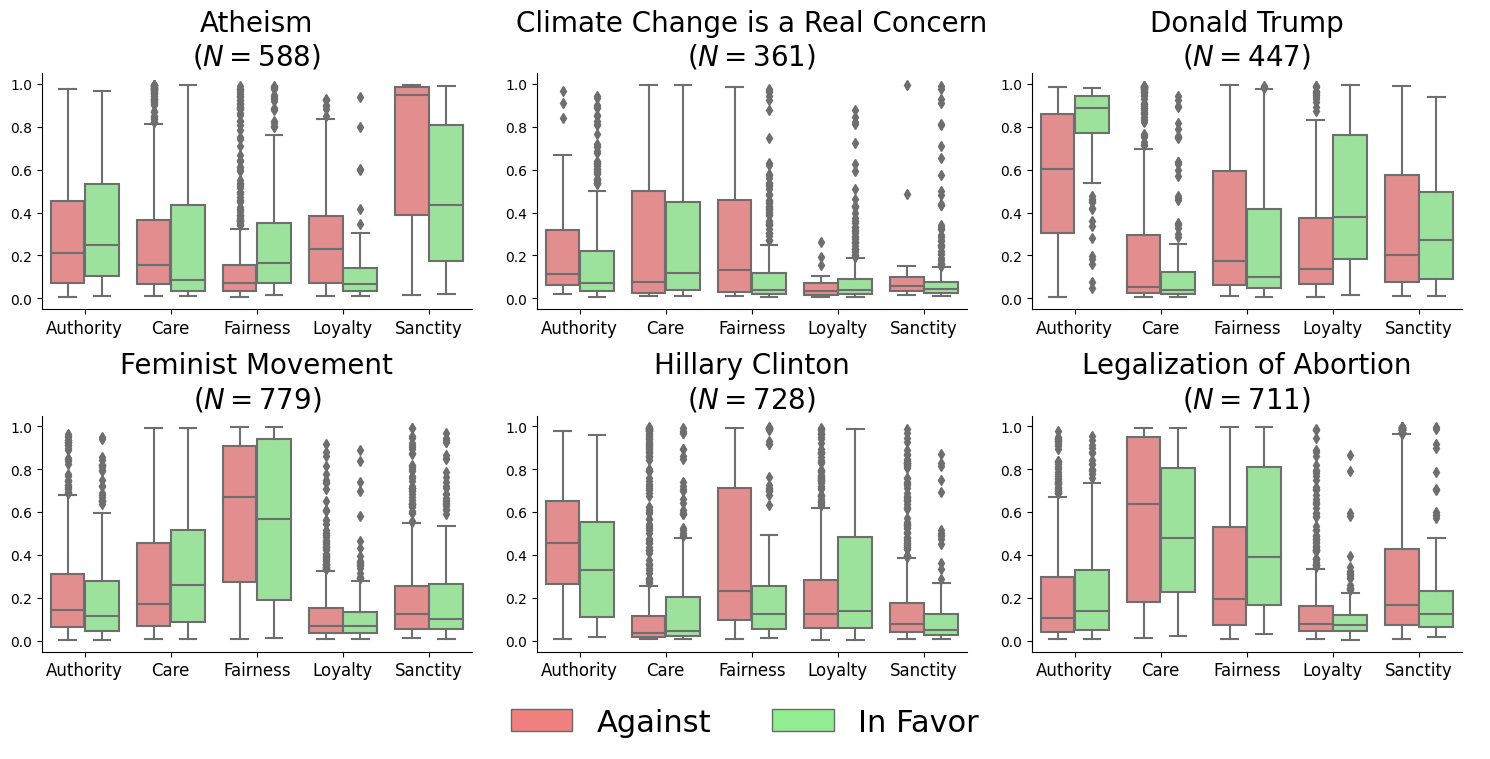

In [9]:
from matplotlib.patches import Patch

topics = sorted(stance.target.unique())
scores_by_topic = {t: build_data_for_comparison(stance, t) for t in topics}

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
for topic, ax in zip(topics, axes.flatten()):
    
    n = stance[(stance.target == topic) & (stance.stance != "NONE")].shape[0]
    
    palette = {"AGAINST": "lightcoral", "FAVOR": "lightgreen"}
    sns.boxplot(data=scores_by_topic[topic],
                x="foundation", y="score", hue="stance",
                palette=palette, ax=ax,
                hue_order=["AGAINST", "FAVOR"])
    ax.legend([],[], frameon=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_ylim([-0.05, 1.05])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(topic + "\n" + f"($N={n}$)", size=20)
    ax.set_xticklabels([f.capitalize() for f in FOUNDATIONS], size=12)
    sns.despine(ax=ax)
fig.tight_layout()

legend_elements = [Patch(facecolor='lightcoral', edgecolor='dimgray', label='Against'),
                   Patch(facecolor='lightgreen', edgecolor='dimgray', label='In Favor')]

fig.legend(handles=legend_elements,
           frameon=False,
           ncol=4,
           prop={'size': 22},
           loc="lower center",
           bbox_to_anchor=(0.5, -0.1, 0, 0))

plt.savefig("figs/twitter_stance/twitter_stance_scores_per_topic.pdf", bbox_inches="tight")
plt.show()

### Mann-Whitney U test

In [10]:
from scipy.stats import mannwhitneyu
mw_res_all = {}
for topic in topics:
    df = stance[stance.target == topic]
    df_favor = df[df.stance == "FAVOR"]
    df_against = df[df.stance == "AGAINST"]
    
    mw_res = pd.DataFrame(0, index=FOUNDATIONS,
                          columns=["Median FAVOR score", "Median AGAINST score", 
                                   "Stance", "U", "p-value"])
    for foundation in FOUNDATIONS:
        s_favor = df_favor[foundation + "_score"]
        s_against = df_against[foundation + "_score"]
        result = mannwhitneyu(x=s_favor, y=s_against)
        mw_res.loc[foundation, "Median FAVOR score"] = s_favor.median()
        mw_res.loc[foundation, "Median AGAINST score"] = s_against.median()
        if result.pvalue < 0.05:
            mw_res.loc[foundation, "Stance"] = "FAVOR" if s_favor.median() > s_against.median() else "AGAINST"
        else:
            mw_res.loc[foundation, "Stance"] = "-"
        mw_res.loc[foundation, "U"] = result.statistic
        mw_res.loc[foundation, "p-value"] = f"{result.pvalue:.1e}"
    mw_res_all[topic] = mw_res

In [11]:
topic = "Donald Trump"
print(topic)
mw_res_all[topic]

Donald Trump


,Median FAVOR score,Median AGAINST score,Stance,U,p-value
authority,0.885642,0.605457,FAVOR,33172,8.4e-18
care,0.039165,0.053197,AGAINST,18751,8.7e-03
fairness,0.097189,0.174632,AGAINST,18697,7.6e-03
loyalty,0.379255,0.138921,FAVOR,30919,7.9e-12
sanctity,0.270681,0.201550,-,22923,5.4e-01


## Comparison using binary predictions

### Turning RoBERTa score to binary predictions

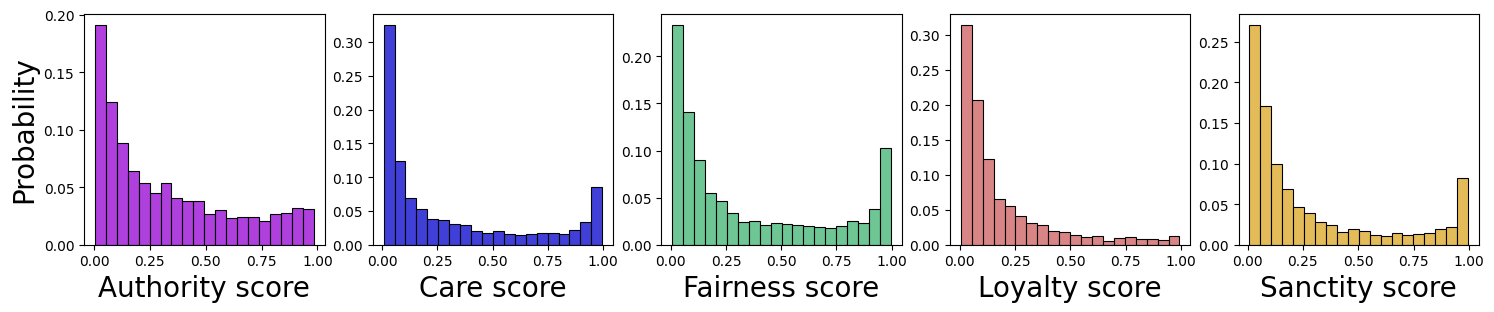

In [12]:
# Plot distribution of raw scores
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    y_score = stance[foundation + "_score"]
    hist = sns.histplot(y_score, ax=ax, color=color, bins=20, stat="probability")# clip=[0, 1])
    ax.set_ylabel("")
    ax.set_xlabel(foundation.capitalize() + " score", size=20)
axes[0].set_ylabel("Probability", size=20)
plt.savefig("figs/twitter_stance/roberta_score_distribution.pdf", bbox_inches="tight")
plt.show()

In [13]:
from utils.thresholding import threshold_top_x

# Xth percentile = threshold (aka top (100-X)% of scores become label 1)
LEVEL = 80

## Binarize
for f in FOUNDATIONS:
    f_thresh = threshold_top_x(stance[f + "_score"], x=LEVEL)
    stance[f + "_pred"] = np.array([y > f_thresh for y in stance[f + "_score"]], dtype=int)

### Contingency table

In [14]:
from sklearn.metrics.cluster import contingency_matrix

def twitter_stance_cont_matrix(foundation, target, stance=stance):
    # Only get examples for this target topic and remove NONE
    stance = stance[(stance.target == target) & (stance.stance != "NONE")]
    
    t = np.array(stance["stance"] == "FAVOR", dtype=int)
    f = stance[foundation + "_pred"].to_numpy()
    matrix = contingency_matrix(t, f)
    matrix = pd.DataFrame(matrix, 
                          index=["IN FAVOR", "AGAINST"],
                          columns=["Contains " + foundation, "Does not contain " + foundation])
    return matrix

### Chi-square test

In [15]:
from scipy.stats import chi2_contingency

chi2_res = pd.DataFrame("", index=topics, columns=FOUNDATIONS)

for topic in topics:
    for f in FOUNDATIONS:
        matrix = twitter_stance_cont_matrix(foundation=f, target=topic)
        chi2, pvalue, _, _ = chi2_contingency(matrix, correction=False)
        chi2, pvalue = f"{chi2:.2f}", pvalue
        if pvalue < 0.001:
            chi2 += "***"
        elif pvalue < 0.01:
            chi2 += "**"
        elif pvalue < 0.05:
            chi2 += "*"
        else:
            chi2 = "-"
        chi2_res.loc[topic, f] = chi2

print("Chi-squared results: (* p < 0.05, ** p < 0.01, *** p < 0.001)")
chi2_res

Chi-squared results: (* p < 0.05, ** p < 0.01, *** p < 0.001)


,authority,care,fairness,loyalty,sanctity
Atheism,-,-,11.82***,47.58***,46.22***
Climate Change is a Real Concern,-,-,16.55***,-,-
Donald Trump,51.77***,5.90*,-,34.05***,-
Feminist Movement,-,-,-,-,-
Hillary Clinton,-,-,17.55***,-,-
Legalization of Abortion,-,12.21***,11.05***,5.72*,15.13***


### Odds ratios

In [16]:
from scipy.stats import norm

def odds_ratios(matrix, ci=0.95, log=False):
    n00, n01 = matrix[0]
    n10, n11 = matrix[1]
    odds_ratio = (n11 * n00) / (n10 * n01)
    lor = np.log(odds_ratio)
    
    se = np.sqrt(1/n00 + 1/n01 + 1/n10 + 1/n11)
    
    p_value = 2 * norm.cdf(-np.abs(lor) / se)
    
    z = np.abs(norm.ppf((1-ci) / 2))
    
    lower = np.exp(lor - z * se)
    upper = np.exp(lor + z * se)
    if log:
        odds_ratio = np.log(odds_ratio)
        lower = np.log(lower)
        upper = np.log(upper)
    return odds_ratio, (lower, upper), p_value

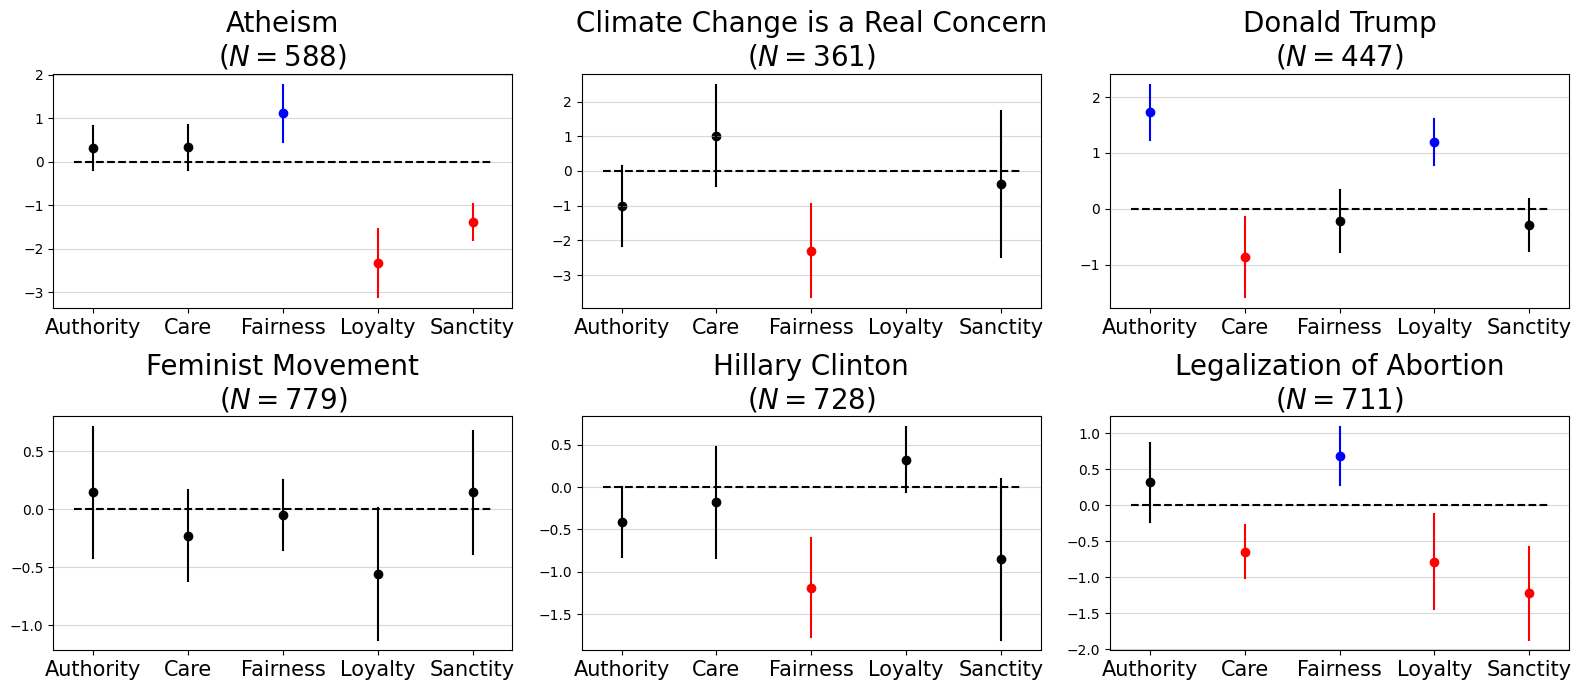

In [17]:
import warnings
warnings.filterwarnings("ignore")
topics = sorted(stance.target.unique())
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for ax_num, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    ors = []
    pvalues = []
    cis = []
    fs = []
    n = stance[(stance.target == topic) & (stance.stance != "NONE")].shape[0]
    for f, color in zip(FOUNDATIONS, COLORS):
        fs.append(f)
        matrix = twitter_stance_cont_matrix(foundation=f,
                                            target=topic)
        o, ci, pv = odds_ratios(matrix.to_numpy(), log=True)
        ors.append(o)
        cis.append(ci)
        pvalues.append(pv)

    for i, f, o, p, ci, color in zip(range(len(fs)), fs, ors, pvalues, cis, COLORS):
        if p >= 0.05: c = "k"
        elif o > 0: c = "blue"
        else: c = "r"
        ax.scatter(f, o, c=c)
        ax.plot((f, f), (ci[0], ci[1]), c=c)
    # ax.set_xlim((0, 10))
    ax.grid(axis="y", alpha=0.5)
    ax.set_xticks([0, 1, 2, 3, 4], ["Authority", "Care", "Fairness", "Loyalty", "Sanctity"], size=15)
    ax.set_title(topic + "\n" + f"($N={n}$)", size=20)
    ax.plot((-0.2, 4.2), (0, 0), c="k", linestyle="--")
fig.tight_layout()
plt.savefig("figs/twitter_stance/twitter_stance_ORs_per_topic.pdf", bbox_inches="tight")

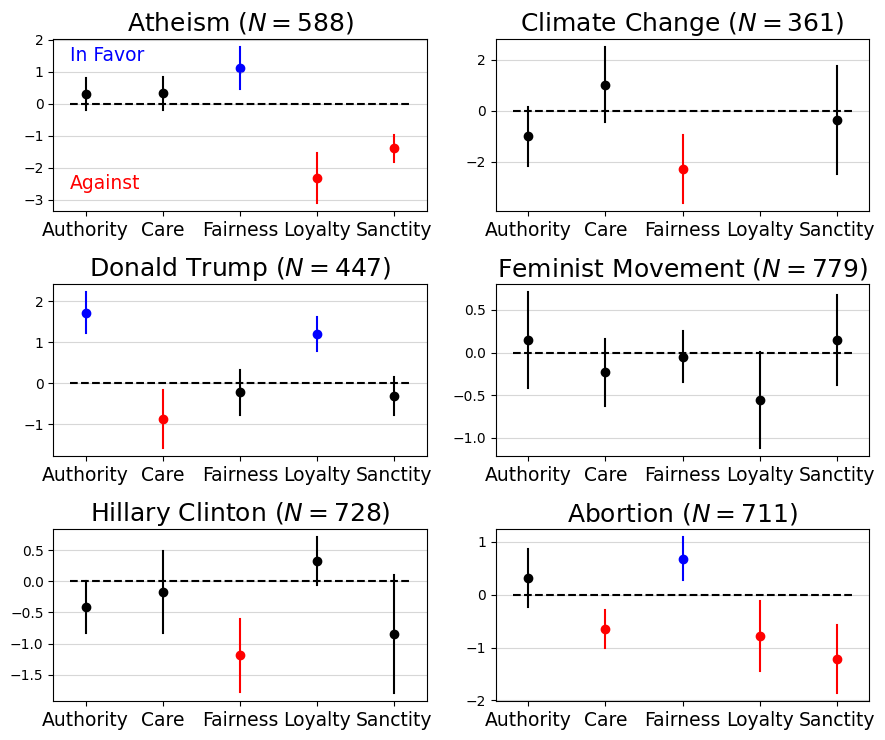

In [18]:
import warnings
warnings.filterwarnings("ignore")
topics = sorted(stance.target.unique())
fig, axes = plt.subplots(3, 2, figsize=(9, 7.5))
for ax_num, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    ors = []
    pvalues = []
    cis = []
    fs = []
    n = stance[(stance.target == topic) & (stance.stance != "NONE")].shape[0]
    for f, color in zip(FOUNDATIONS, COLORS):
        fs.append(f)
        matrix = twitter_stance_cont_matrix(foundation=f,
                                            target=topic)
        o, ci, pv = odds_ratios(matrix.to_numpy(), log=True)
        ors.append(o)
        cis.append(ci)
        pvalues.append(pv)

    for i, f, o, p, ci, color in zip(range(len(fs)), fs, ors, pvalues, cis, COLORS):
        if p >= 0.05: c = "k"
        elif o > 0: c = "blue"
        else: c = "r"
        ax.scatter(f, o, c=c)
        ax.plot((f, f), (ci[0], ci[1]), c=c)
    # ax.set_xlim((0, 10))
    ax.grid(axis="y", alpha=0.5)
    ax.set_xticks([0, 1, 2, 3, 4], ["Authority", "Care", "Fairness", "Loyalty", "Sanctity"], size=13.5)
    title = topic
    if title == "Climate Change is a Real Concern": title = "Climate Change"
    if title == "Legalization of Abortion": title = "Abortion"
    ax.set_title(title + f" ($N={n}$)", size=18)
    ax.plot((-0.2, 4.2), (0, 0), c="k", linestyle="--")
fig.tight_layout()

axes[0, 0].text(x=-0.2, y=1.5, s="In Favor", size=13.5, c="blue", va="center")
axes[0, 0].text(x=-0.2, y=-2.5, s="Against", size=13.5, c="red", va="center")

plt.savefig("figs/twitter_stance/twitter_stance_ORs_per_topic.pdf", bbox_inches="tight")